In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.1-py2.py3-none-any.whl size=249152215 sha256=72ee1a02e5f0cd19e2b4a8e69c7136ac55e1dc3a83bd3491880b92de1164aa9b
  Stored in directory: /root/.cache/pip/wheels/2e/2f/04/ef0554c89bcb5d38a6fc082a87f497933109faefd94dcdc3d2
Successfully built h2o


In [ ]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML


## Fix utf
# Carregue o arquivo CSV em um DataFrame usando a codificação UTF-16
df = pd.read_csv('/content/cars_train.csv', encoding='utf-16', sep="\t", skipinitialspace=True)

# # Salve o DataFrame em um novo arquivo CSV usando a codificação UTF-8
df.to_csv('/content/cars_train_.csv', index=False, encoding='utf-8')

# Carregue o arquivo CSV em um DataFrame usando a codificação UTF-16
df = pd.read_csv('/content/cars_test.csv', encoding='utf-16', sep="\t", skipinitialspace=True)

# # Salve o DataFrame em um novo arquivo CSV usando a codificação UTF-8
df.to_csv('/content/cars_test_.csv', index=False, encoding='utf-8')

In [ ]:
train_data = h2o.import_file("/content/cars_train_.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Inicialize o servidor H2O
h2o.init()

# Carregue os dados de treinamento e teste
train_data = (
    h2o.import_file("/content/cars_train_.csv")
    .drop(["id", "dono_aceita_troca", "veiculo_único_dono", "revisoes_concessionaria",
          "ipva_pago", "veiculo_licenciado", "garantia_de_fábrica", "revisoes_dentro_agenda"])
    )

# train_data = train_data.

# Remova outliers da coluna "preco"
mean = train_data["preco"].mean()[0]
std = train_data["preco"].sd()[0]
threshold = 2  # Defina o limite de desvio padrão para identificar outliers

lower_bound = mean - (std * threshold)
upper_bound = mean + (std * threshold)

train_data_ = train_data[(train_data["preco"] >= lower_bound) & (train_data["preco"] <= upper_bound), :]

# # test_data = h2o.import_file("/content/cars_test_.csv")
train_data, test_data = train_data_.split_frame(ratios=[0.8])


# Defina as colunas a serem usadas para treinamento e a variável de destino
x = train_data.columns[:-1]  # Todas as colunas, exceto a coluna alvo
y = "preco"  # Coluna alvo (variável a ser prevista)

# Crie um modelo de Gradient Boosting Machines (GBM)
model = H2OAutoML(max_models = 5, max_runtime_secs=300, seed = 1, verbosity="debug")
model.train(x=x, y=y, training_frame=train_data)

# Faça as previsões no conjunto de teste
predictions = model.predict(test_data)

# Converta as previsões para um DataFrame do pandas
predictions_df = predictions.as_data_frame()

# Salve as previsões em um arquivo CSV
# predictions_df.to_csv("predicted.csv", index=False)

# Encerre o servidor H2O
# h2o.shutdown()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 48 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_xyl6or
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.868 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:38:19.550: Project: AutoML_11_20230713_103819
10:38:19.550: 5-fold cross-validation will be used.
10:38:19.550: Setting stopping tolerance adaptively based on the training frame: 0.006669186613244856
10:38:19.550: Build control seed: 1
10:38:19.551: training frame: Frame key: AutoML_11_20230713_103819_training_py_1084_sid_8091    cols: 21    rows: 22483  chunks: 8    size: 1053252  checksum: -4431155443628012564
10:38:19.551: validation frame: NULL
10:38:19.551: leaderboard frame: NULL
10:38:19.551: blending frame: NULL
10:38:19.551: response column: preco
10:38:19.551: fold column: null
10:38:19.551: weights column: null
10:38:19.551: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w)

In [ ]:
# lb.head(rows = lb.nrows)
preds = model.predict(test_data)
preds

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
106121
56085.3
246249
63471
76913.4
153490
94454.8
54228.5
82353.8
146495


In [ ]:
lb = model.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_11_20230713_103819,29436.7,8.66517e+08,21938.5,0.26149,8.66517e+08
XGBoost_2_AutoML_11_20230713_103819,30590.7,9.3579e+08,23004.4,0.273144,9.3579e+08
XGBoost_1_AutoML_11_20230713_103819,31144.9,9.70003e+08,23525.9,0.279987,9.70003e+08
GLM_1_AutoML_11_20230713_103819,59385.2,3.5266e+09,47903.5,0.528065,3.5266e+09


In [ ]:
model.model_correlation(frame=test_data)

,GLM_1,GBM_1,XGBoost_1,XGBoost_2
GLM_1,1.000000,0.486165,0.492633,0.496825
GBM_1,0.486165,1.000000,0.956831,0.960987
XGBoost_1,0.492633,0.956831,1.000000,0.969386
XGBoost_2,0.496825,0.960987,0.969386,1.000000


model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_11_20230713_103819,29436.7,8.66517e+08,21938.5,0.26149,8.66517e+08,4170,0.029071,GBM
XGBoost_2_AutoML_11_20230713_103819,30590.7,9.3579e+08,23004.4,0.273144,9.3579e+08,10712,0.008176,XGBoost
GLM_1_AutoML_11_20230713_103819,59385.2,3.5266e+09,47903.5,0.528065,3.5266e+09,540,0.000982,GLM


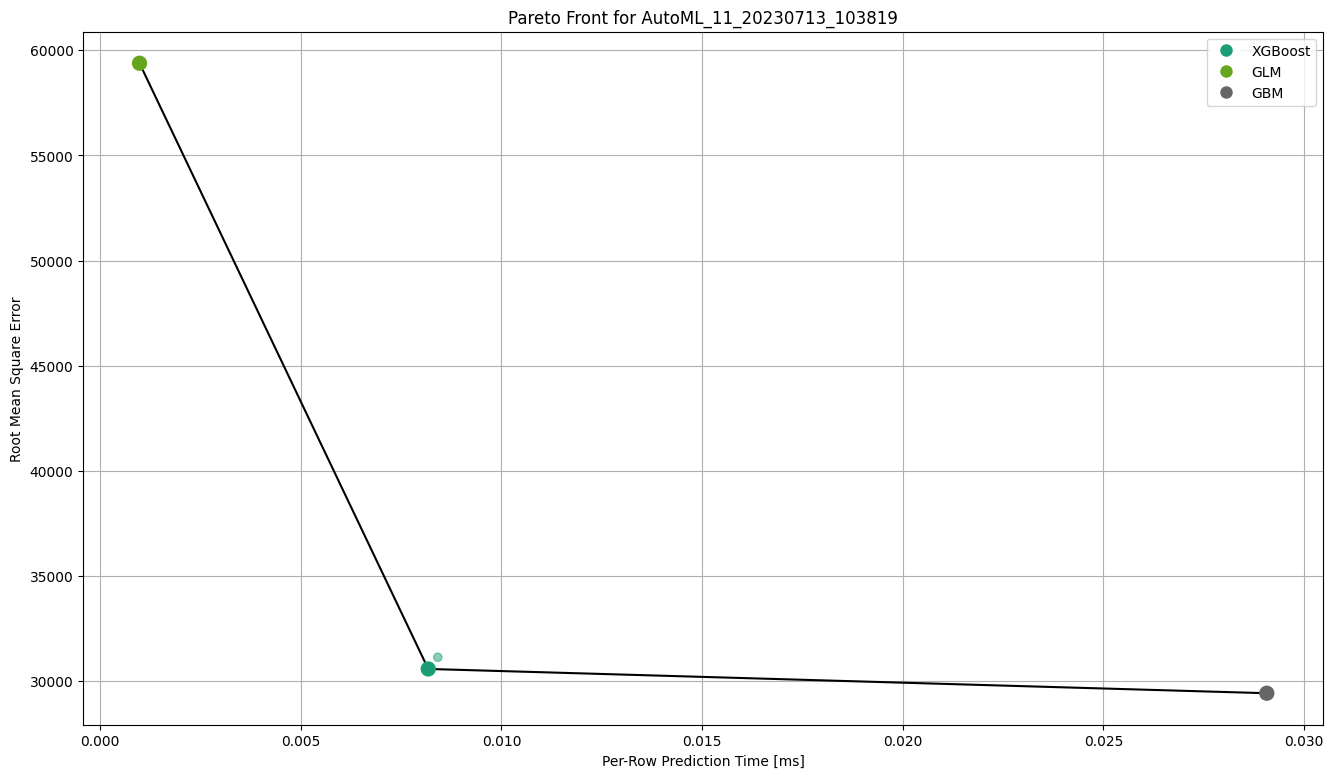

In [ ]:
model.pareto_front()

In [ ]:
model.get_best_model()

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_11_20230713_103819


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    49                 49                          332637                 11           15           14.2245       75            140           124.367

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 542000662.0521789
RMSE: 23280.90767242933
MAE: 17037.46986929187
RMSLE: 0.2052193953314396
Mean Residual Deviance: 542000662.0521789

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 866517316.4171652
RMSE: 29436.666190605978
MAE: 21938.490208039613
RMSLE: 0.26148972171565743
Mean Residual Deviance: 866517316.4171652

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     21954.1      234.857      22081.7       22094.6       21790         22178         21626.2
mean_residual_deviance  8.67601e+08  1.48477e+07  8.85249e+08   8.75893e+08   8.65007e+08   8.66469e+08   8.45384e+08
mse                     8.67601e+08  1.48477e+07  8.85249e+08   8.75893e+08   8.65007e+08   8.66469e+08   8.45384e+08
r2                      0.753672     0.0106141    0.745946      0.747438      0.746463      0.758095      0.770421
residual_deviance       8.67601e+08  1.48477e+07  8.85249e+08   8.75893e+08   8.65007e+08   8.66469e+08   8.45384e+08
rmse                    29454.2      252.463      29753.1       29595.5       29411         29435.8       29075.5
rmsle                   0.261495     0.00160174   0.261385      0.262344      0.263294      0.261467      0.258986

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-07-13 10:39:30  25.493 sec  0                  59382.4          47901           3.52627e+09
    2023-07-13 10:39:31  26.099 sec  5                  42432.7          33964.6         1.80053e+09
    2023-07-13 10:39:31  26.467 sec  10                 33689.1          26610.8         1.13496e+09
    2023-07-13 10:39:32  26.877 sec  15                 29140.2          22520.6         8.49152e+08
    2023-07-13 10:39:32  27.310 sec  20                 26781            20313.4         7.17224e+08
    2023-07-13 10:39:33  27.730 sec  25                 25602.7          19148.5         6.55498e+08
    2023-07-13 10:39:33  28.130 sec  30                 24699.1          18289.3         6.10046e+08
    2023-07-13 10:39:33  28.531 sec  35                 24171.1          17809.4         5.84241e+08
    2023-07-13 10:39:34  28.925 sec  40                 23769.1          17455.4         5.64968e+08
    2023-07-13 10:39:34  29.295 sec  45                 23500.4          17226.8         5.52271e+08
    2023-07-13 10:39:34  29.648 sec  49                 23280.9          17037.5         5.42001e+08

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
modelo             1.22225e+14            1                    0.388409
versao             9.06455e+13            0.741628             0.288055
ano_modelo         2.65191e+13            0.216969             0.0842728
hodometro          1.73518e+13            0.141966             0.0551408
tipo               1.69e+13               0.138269             0.053705
cidade_vendedor   

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_11_20230713_103819,28423.4,8.07887e+08,21337.7,0.258107,8.07887e+08,4170,0.030494,GBM
XGBoost_2_AutoML_11_20230713_103819,29489.2,8.69613e+08,22413.6,0.268177,8.69613e+08,10712,0.011544,XGBoost
XGBoost_1_AutoML_11_20230713_103819,29679.2,8.80855e+08,22458.7,0.270204,8.80855e+08,5168,0.007655,XGBoost
GLM_1_AutoML_11_20230713_103819,58835.7,3.46165e+09,47421.7,0.52469,3.46165e+09,540,0.001012,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

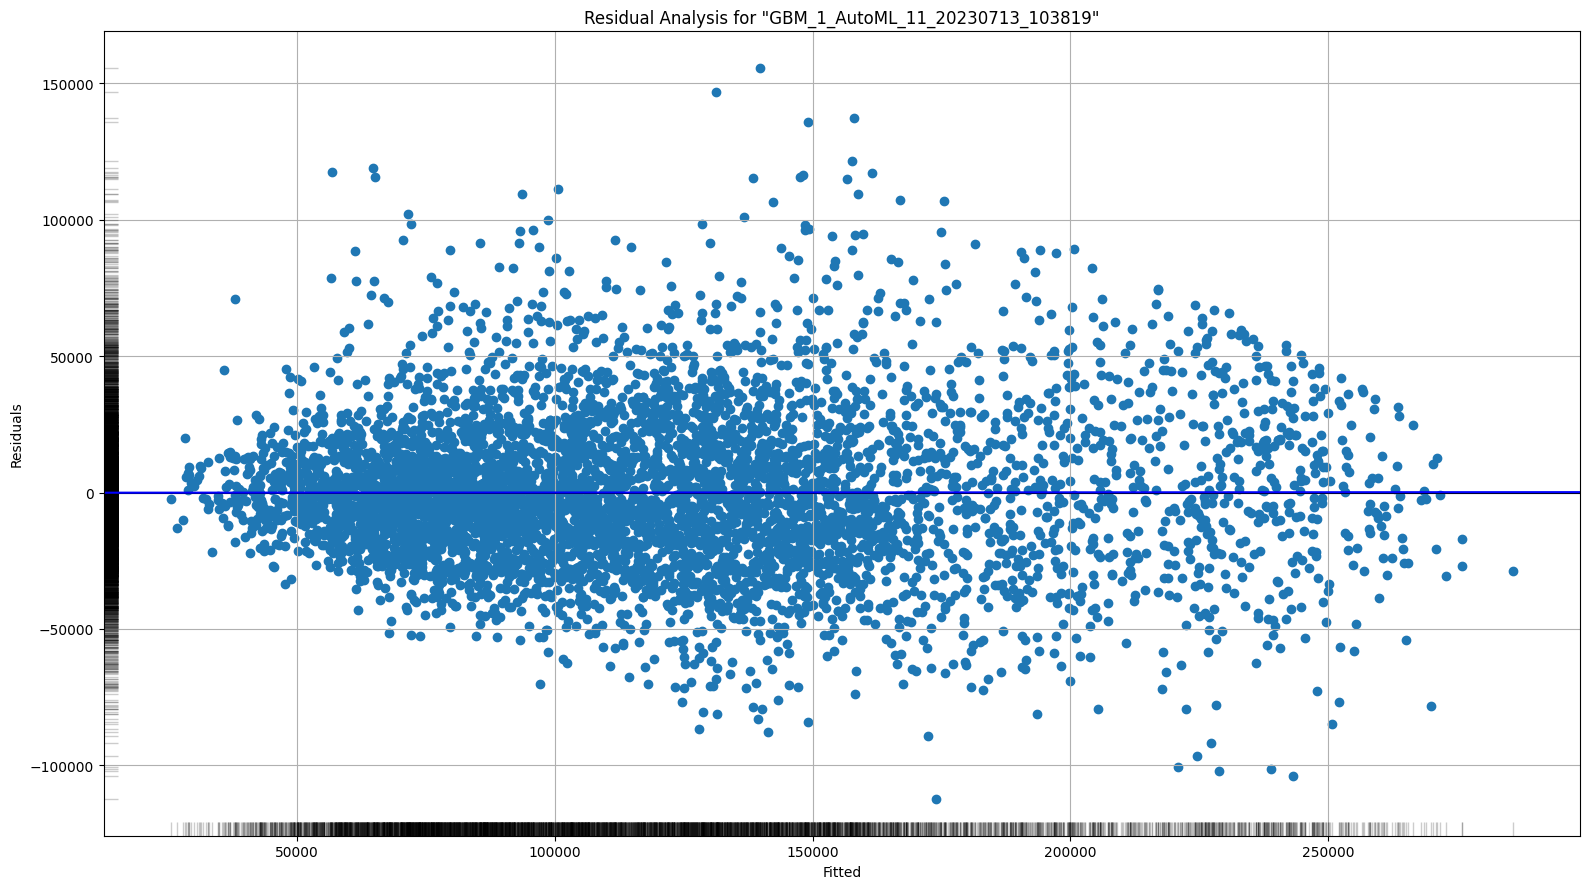

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

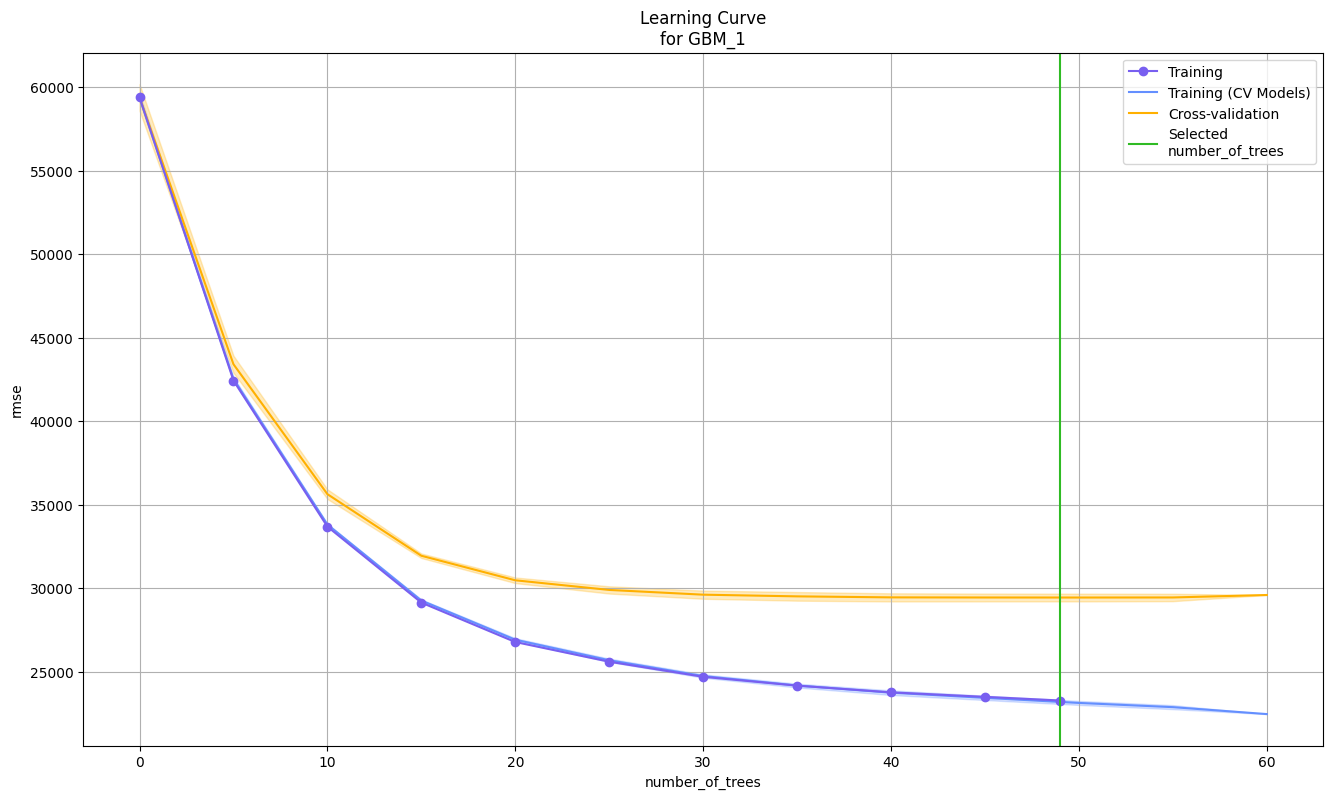

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

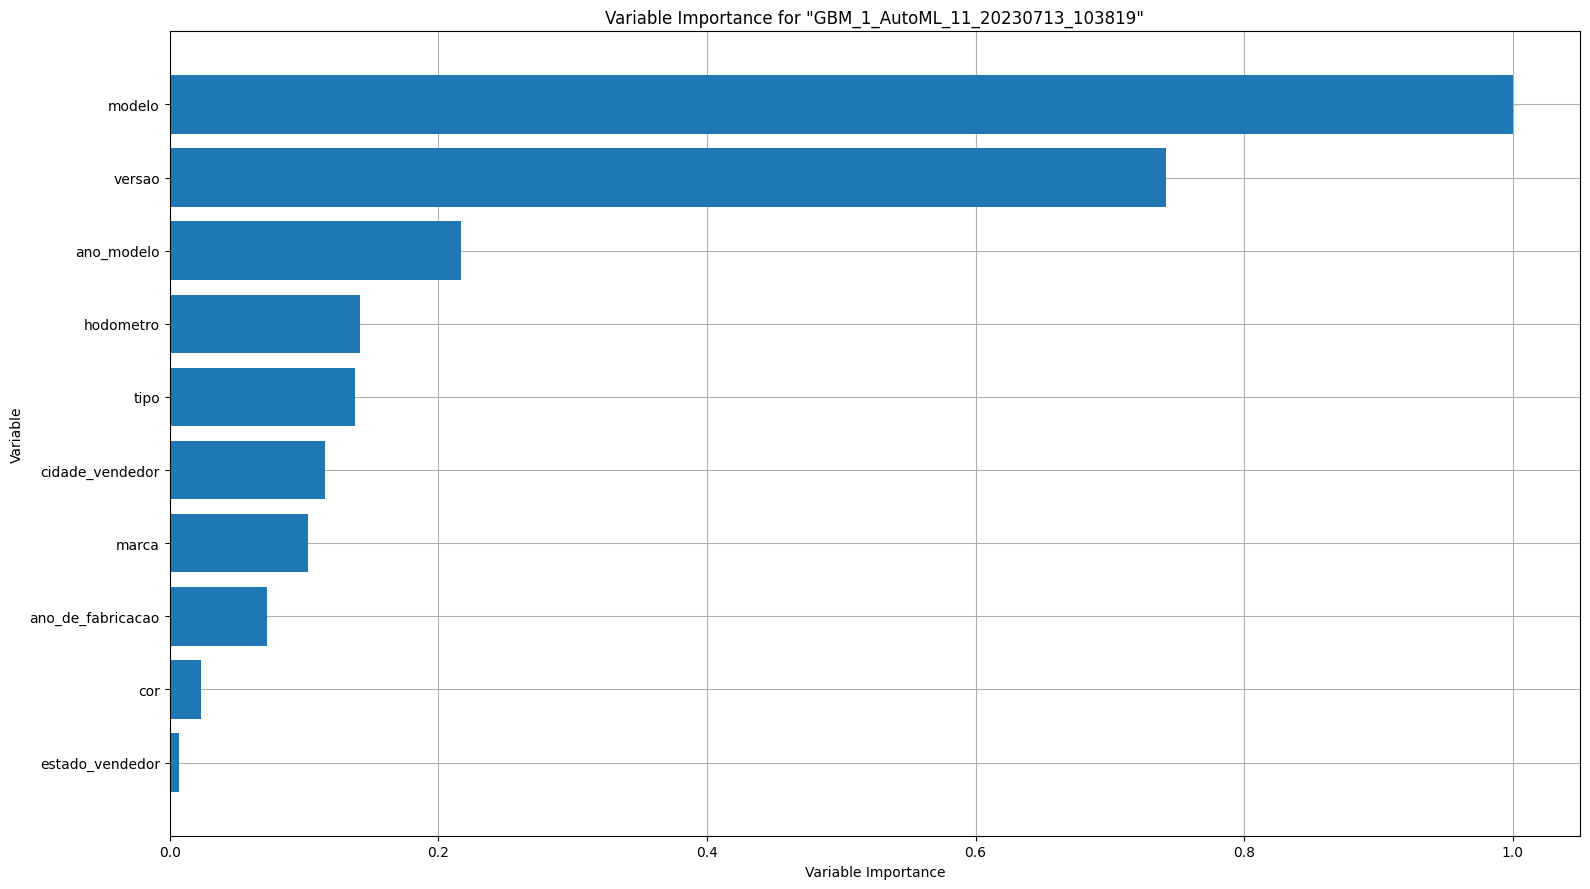

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

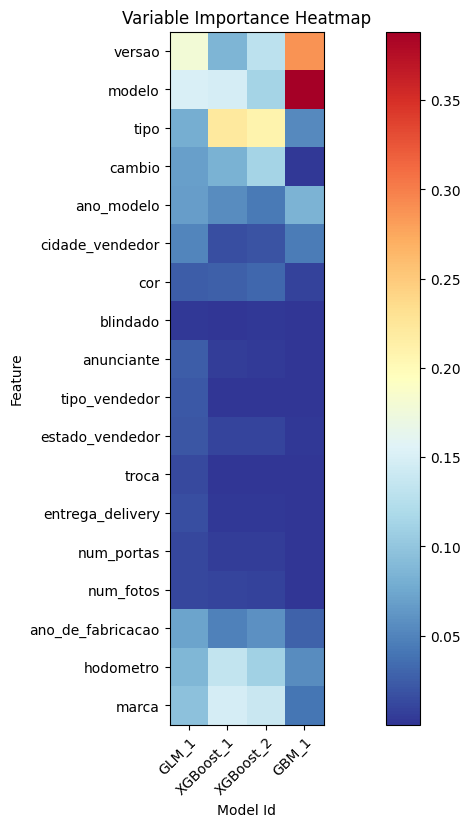

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

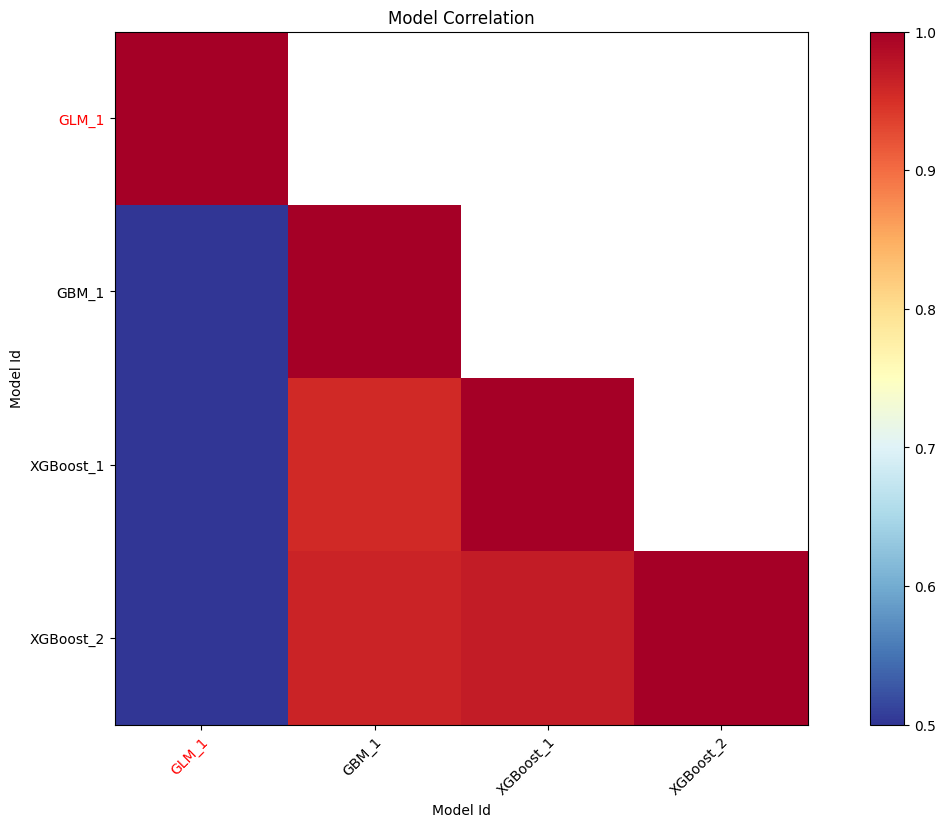

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

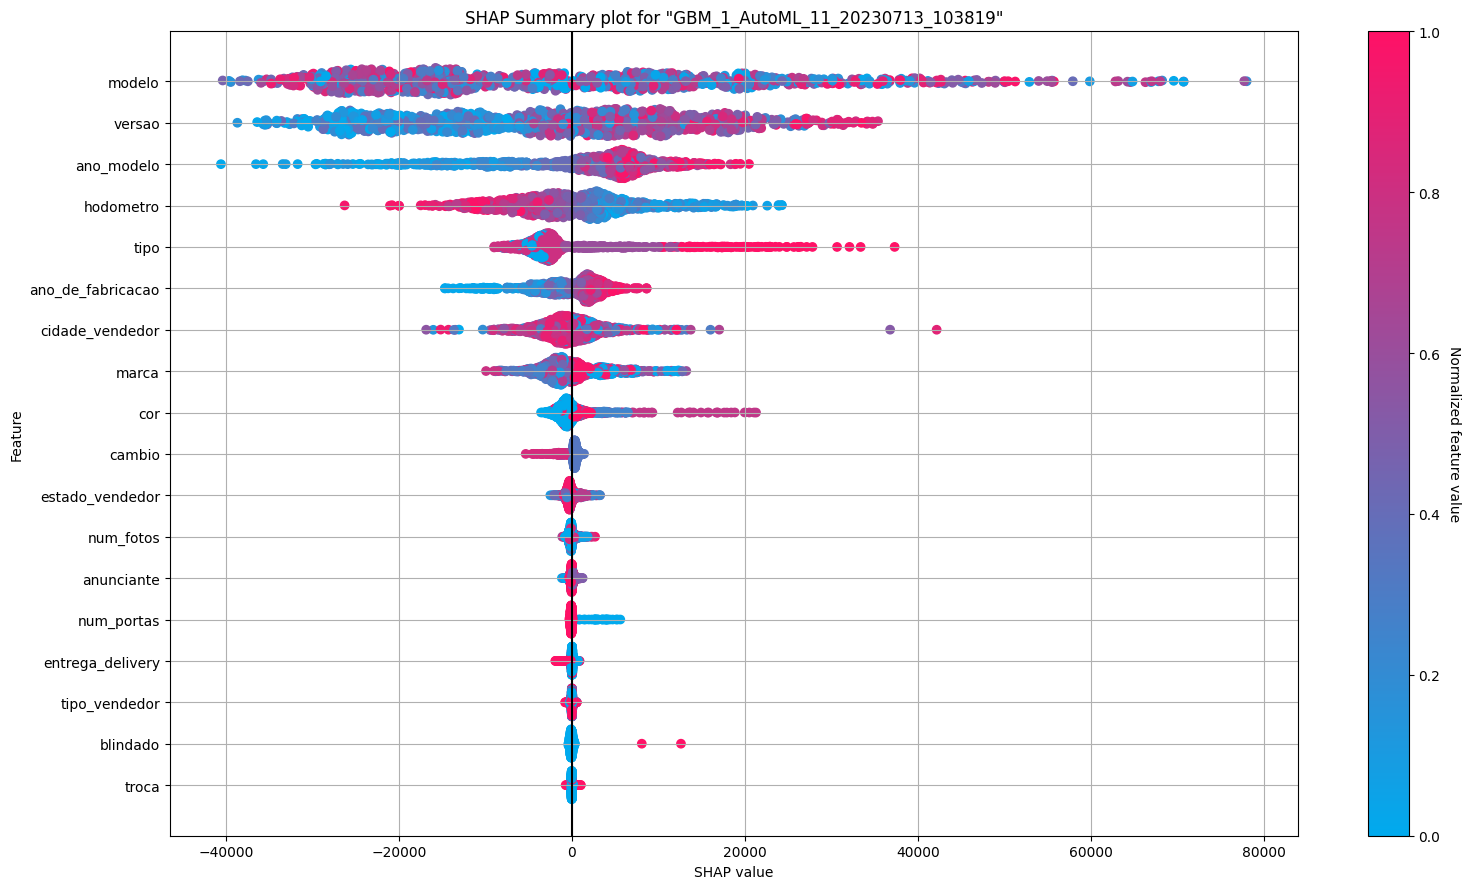

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

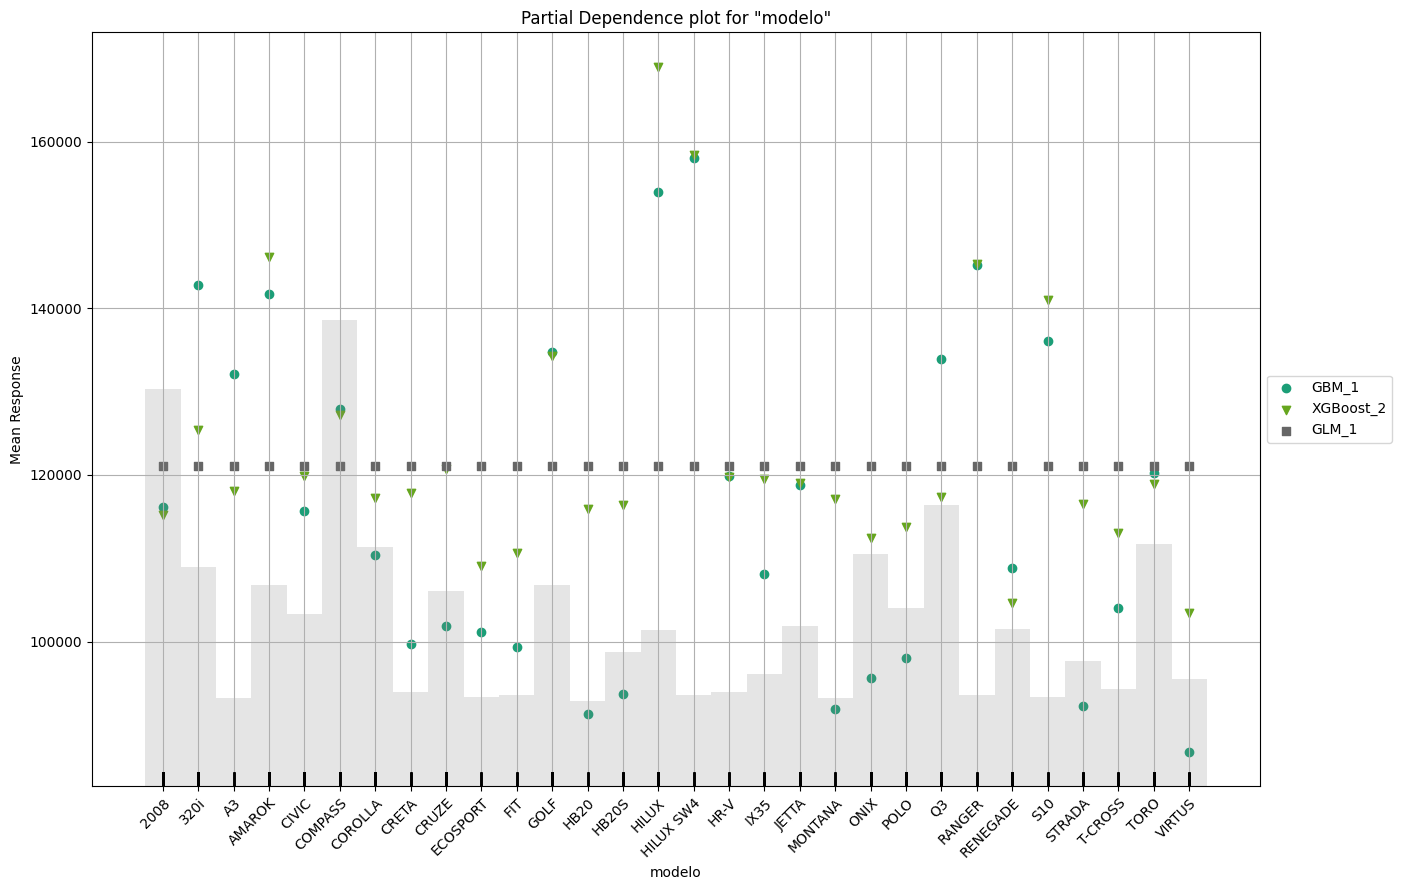

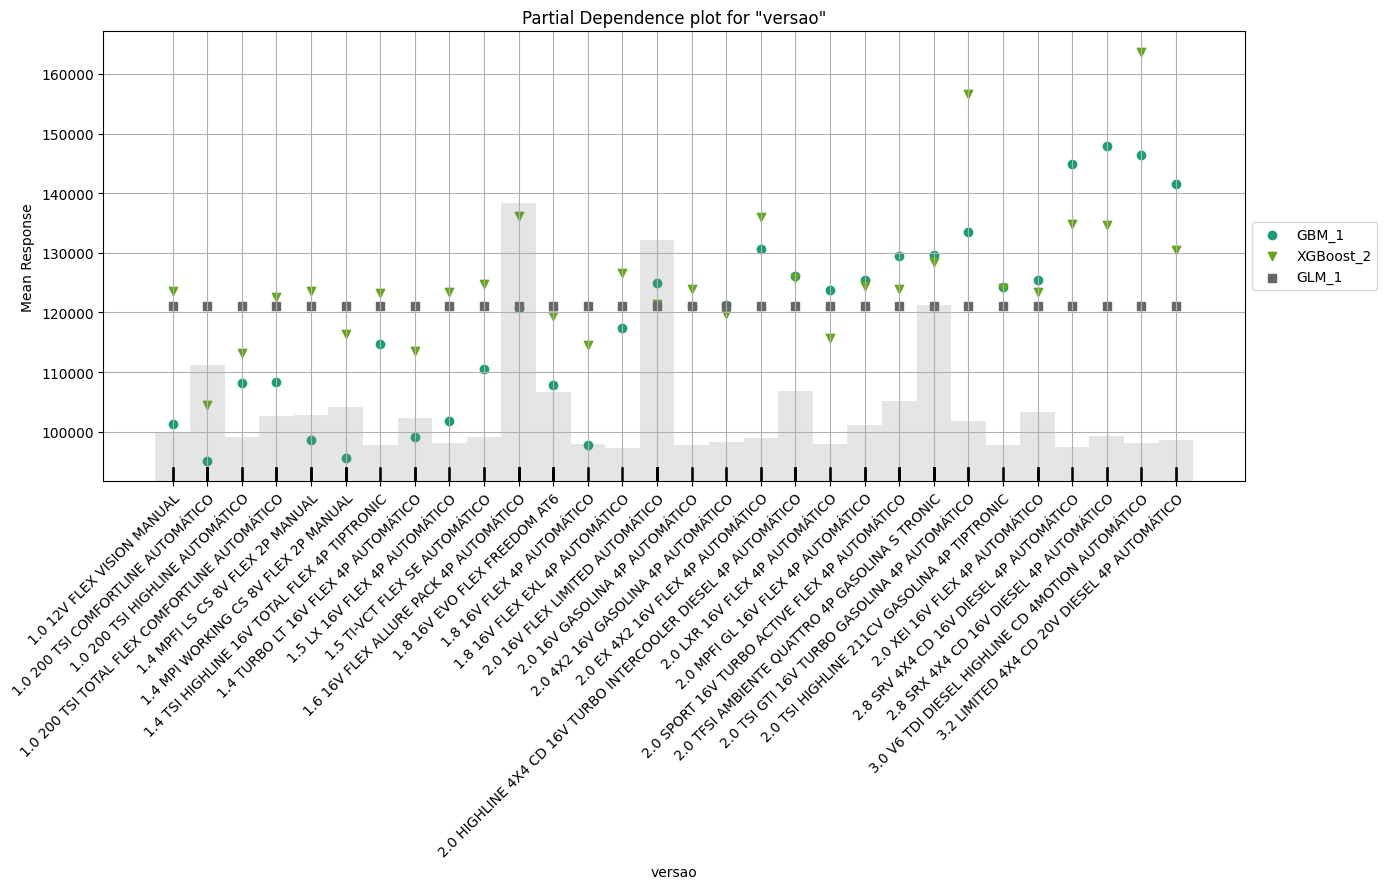

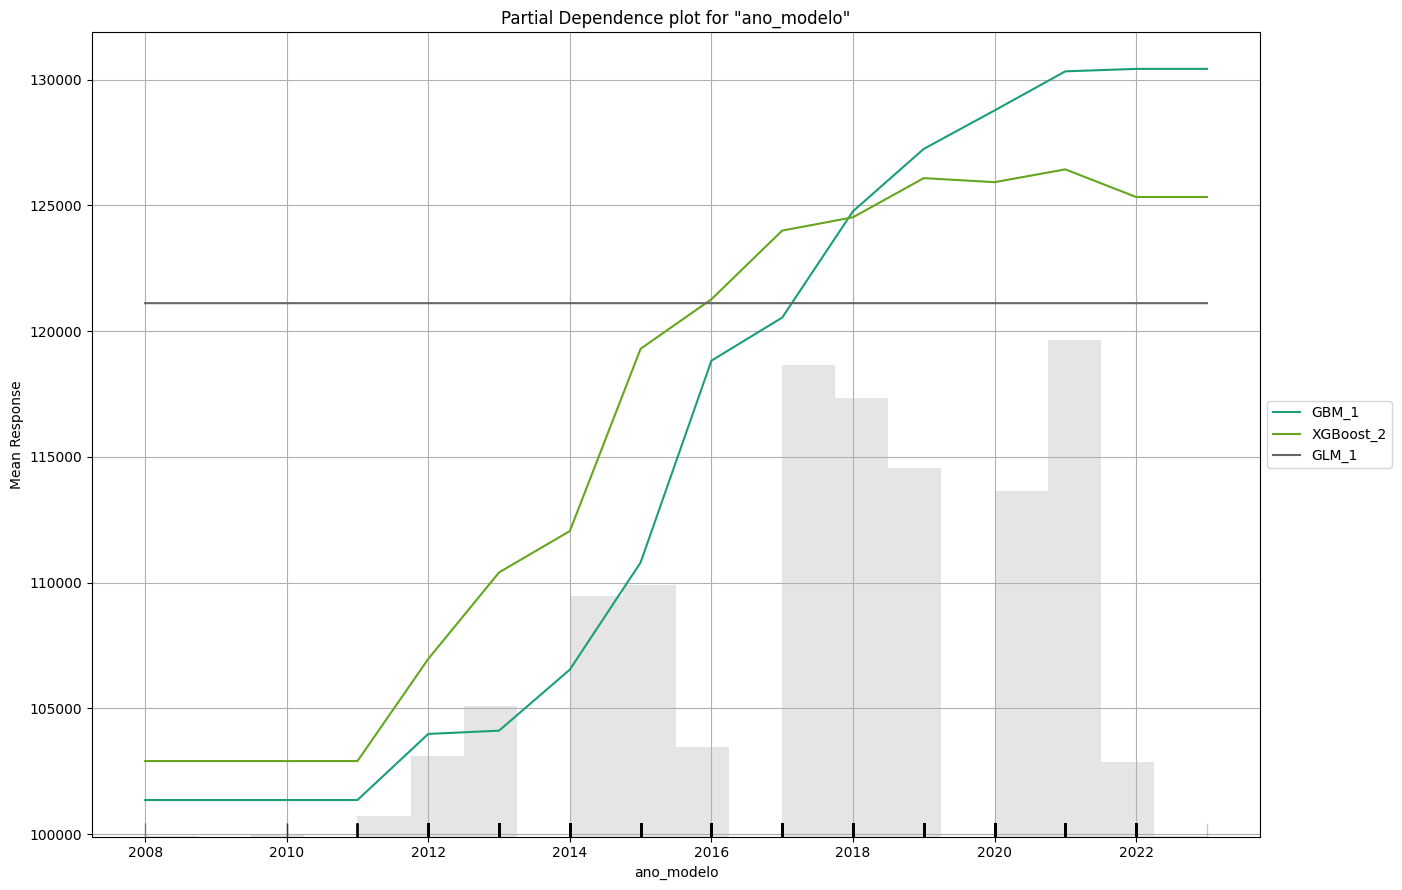

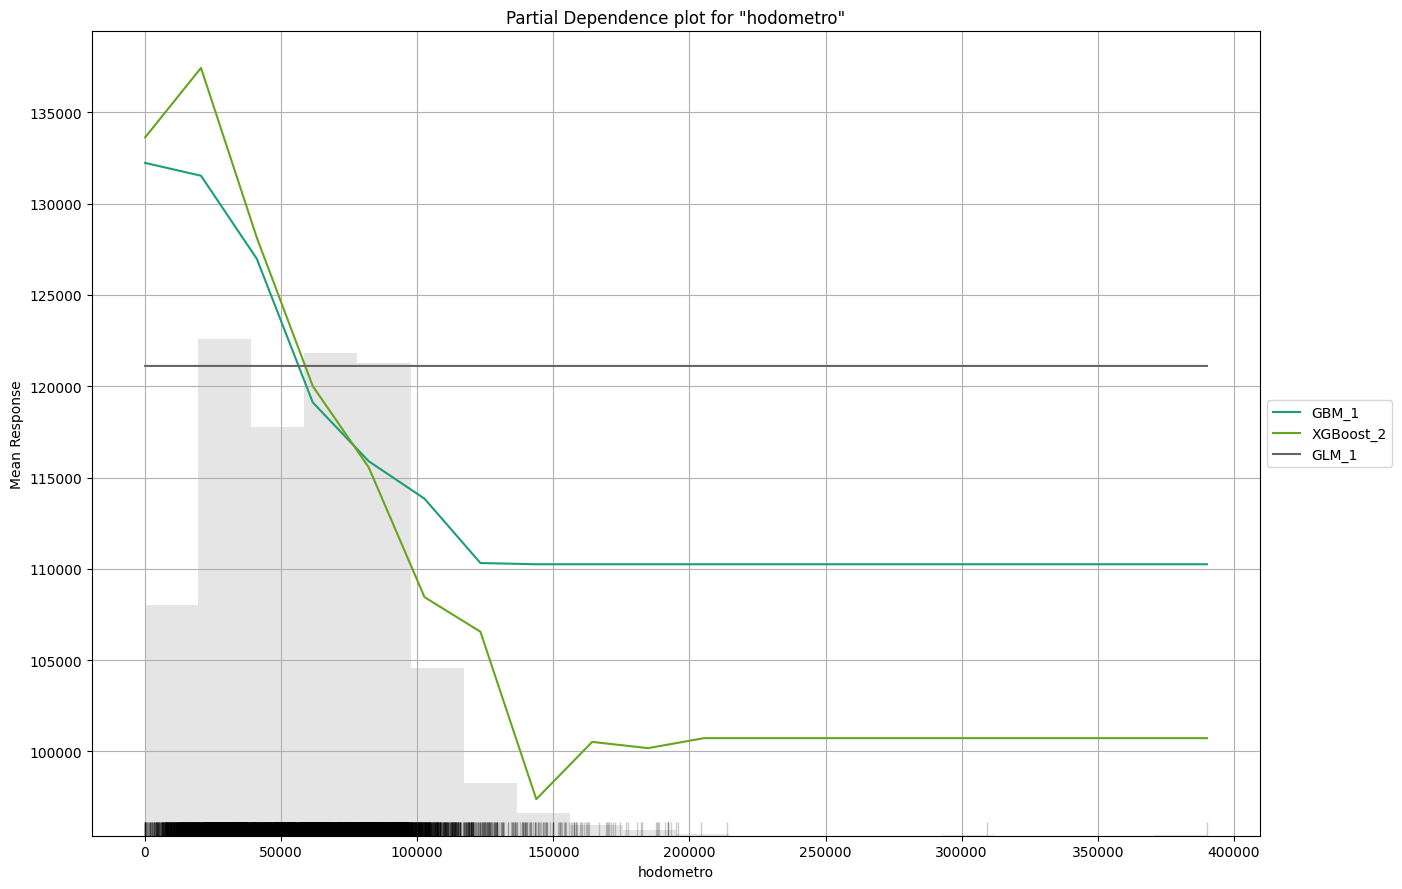

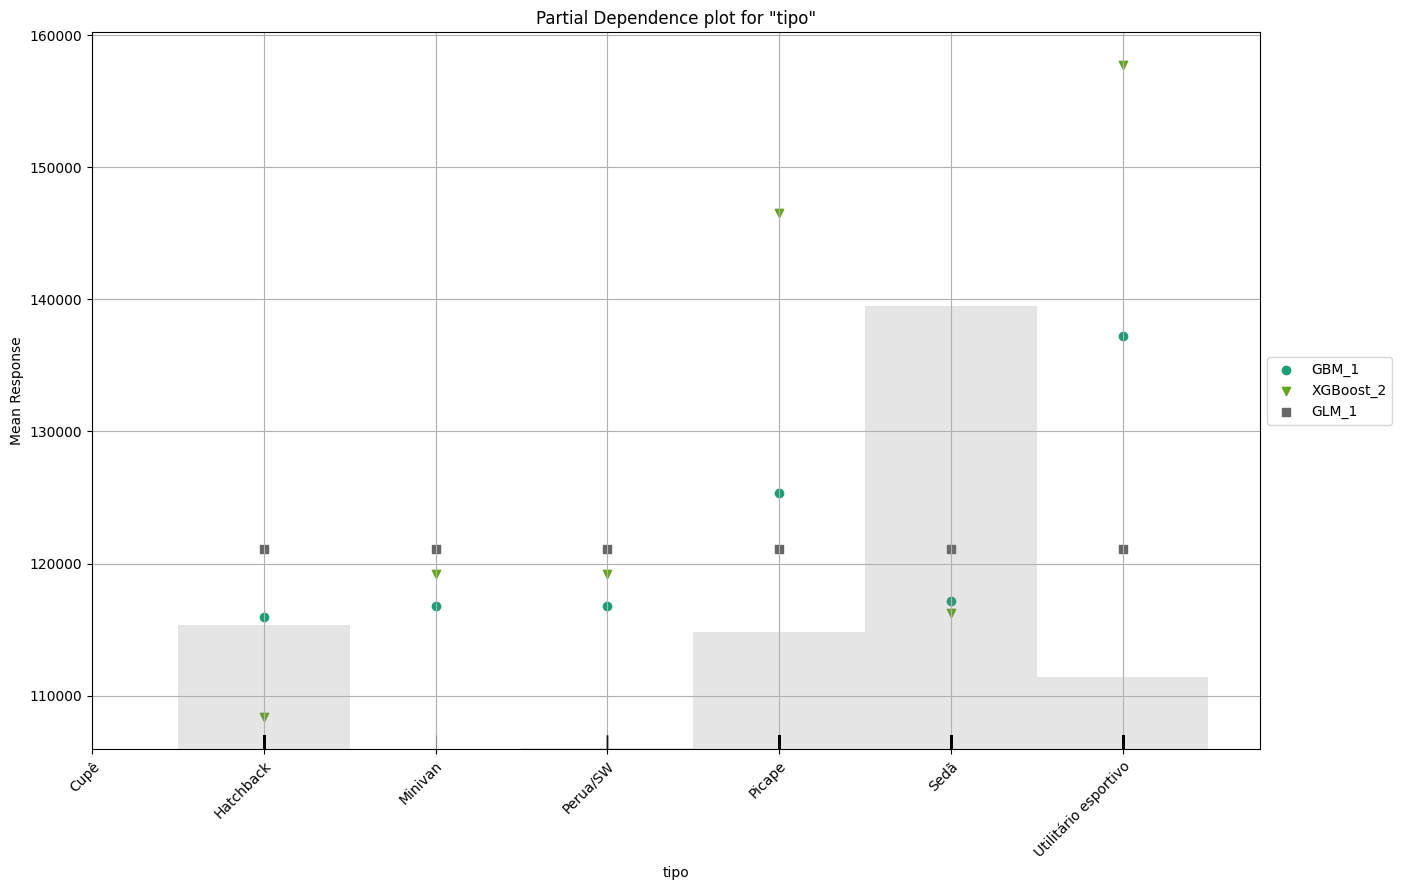

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

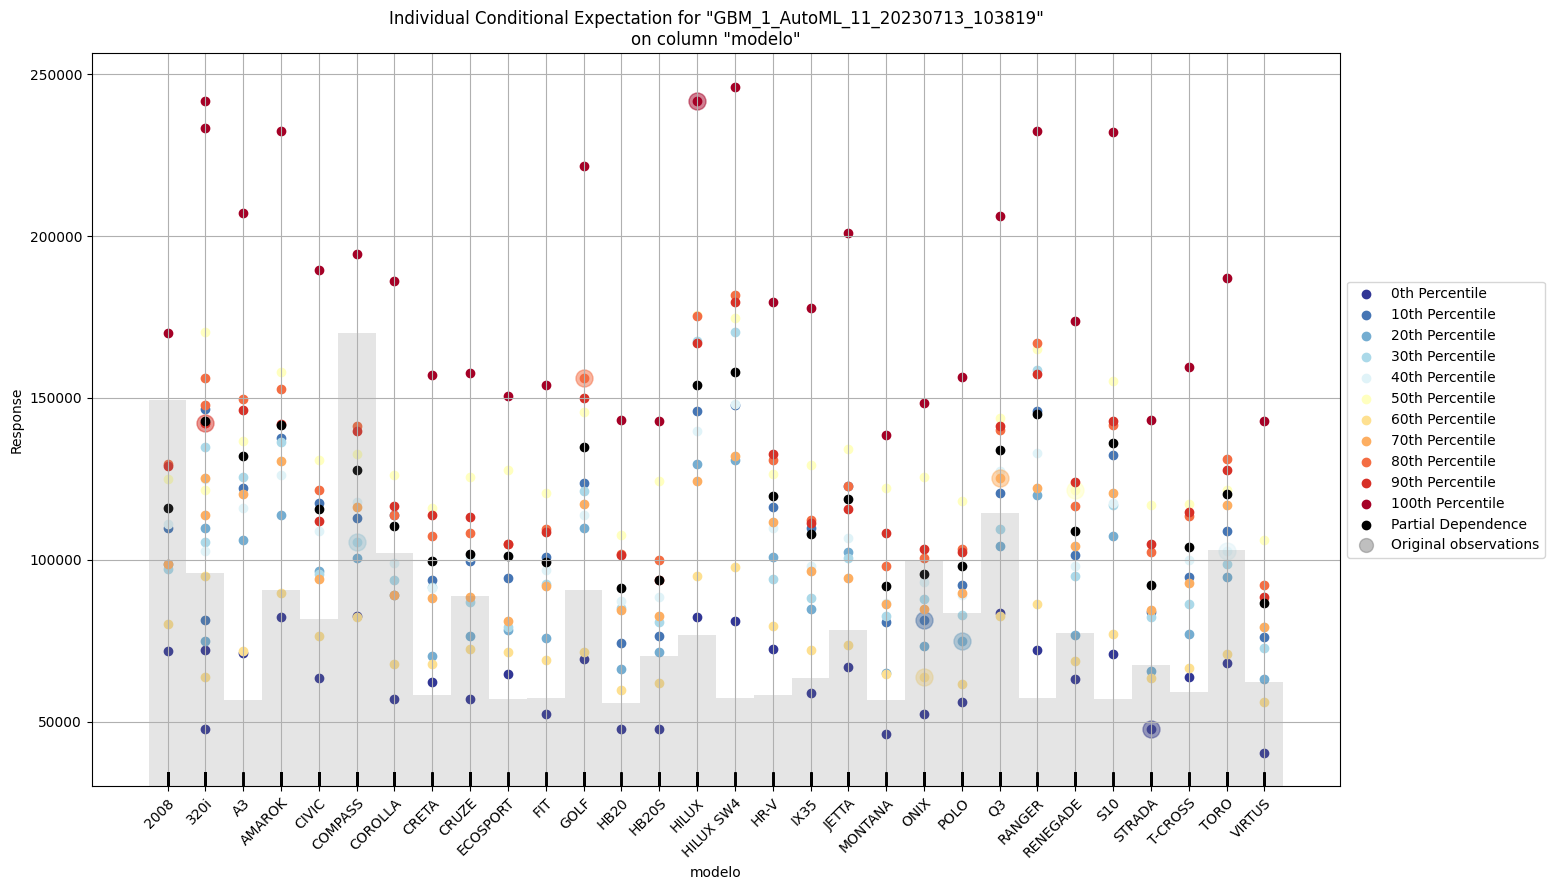

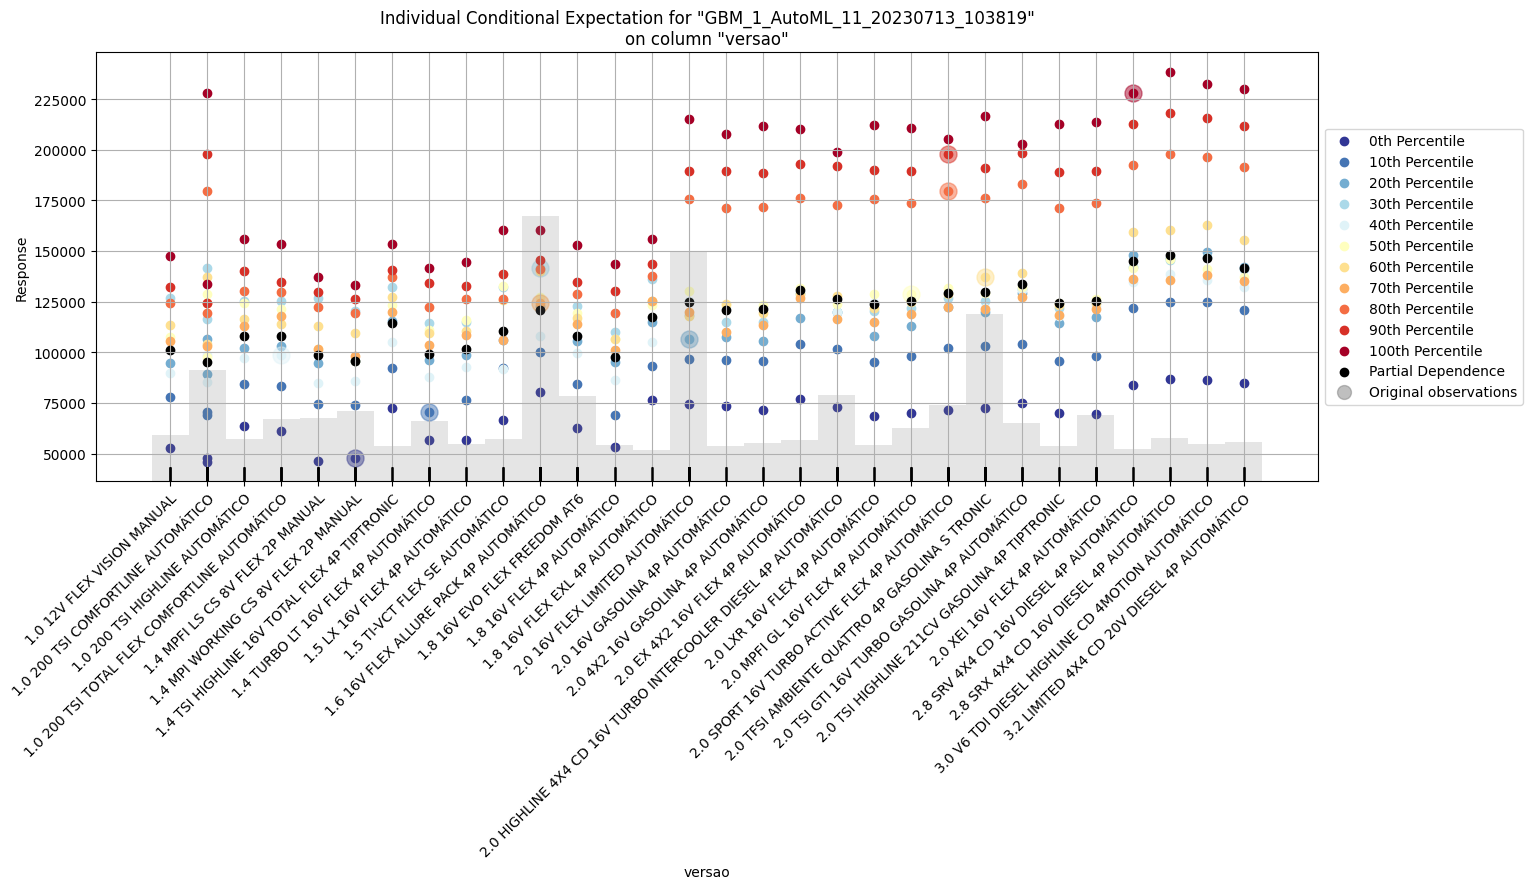

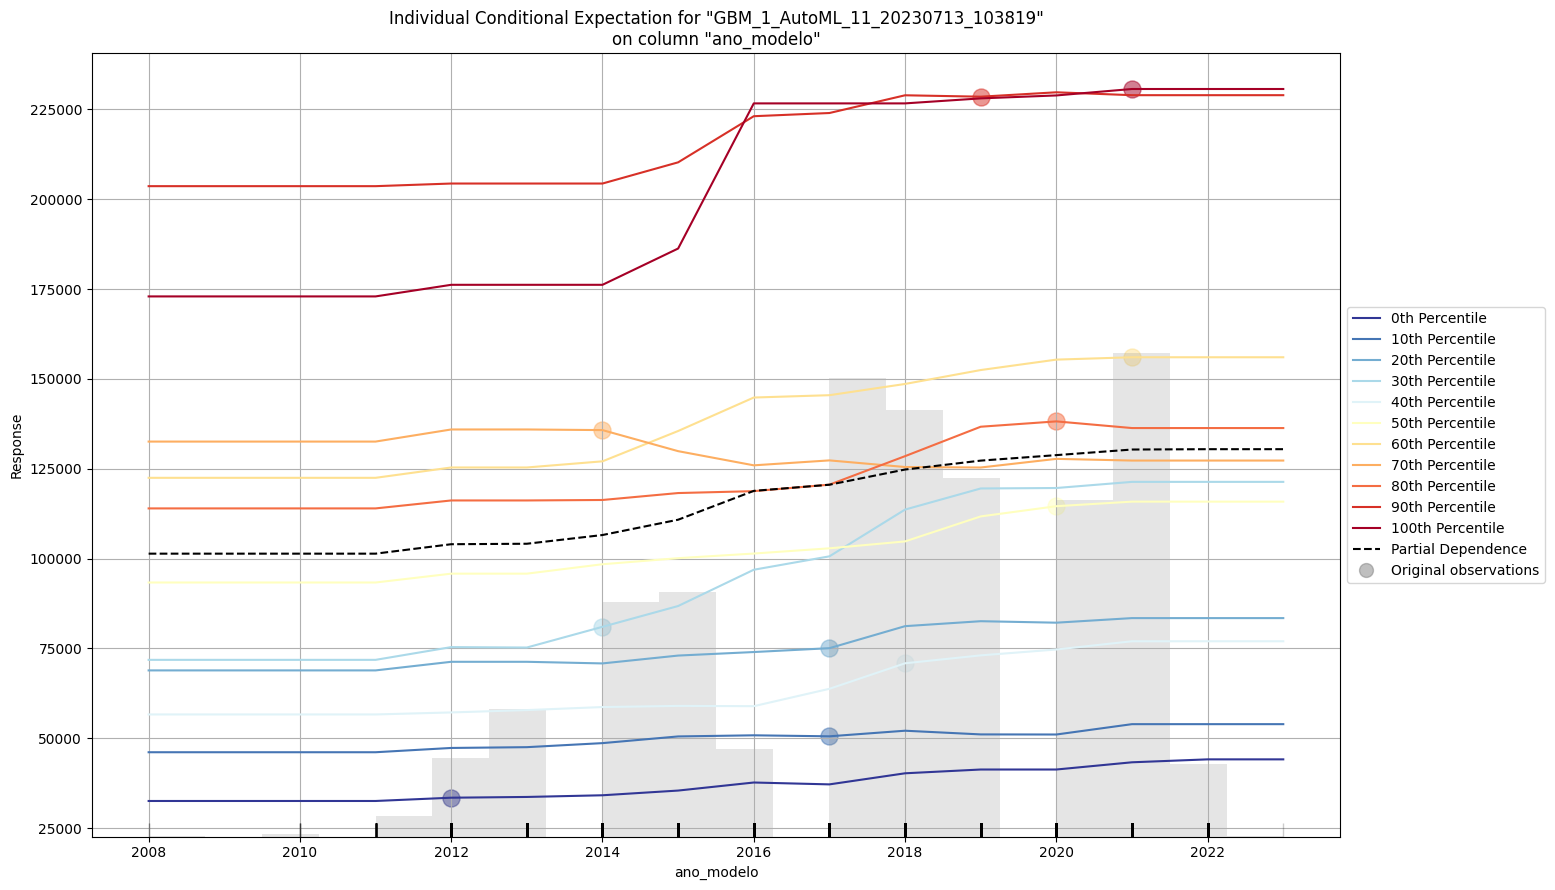

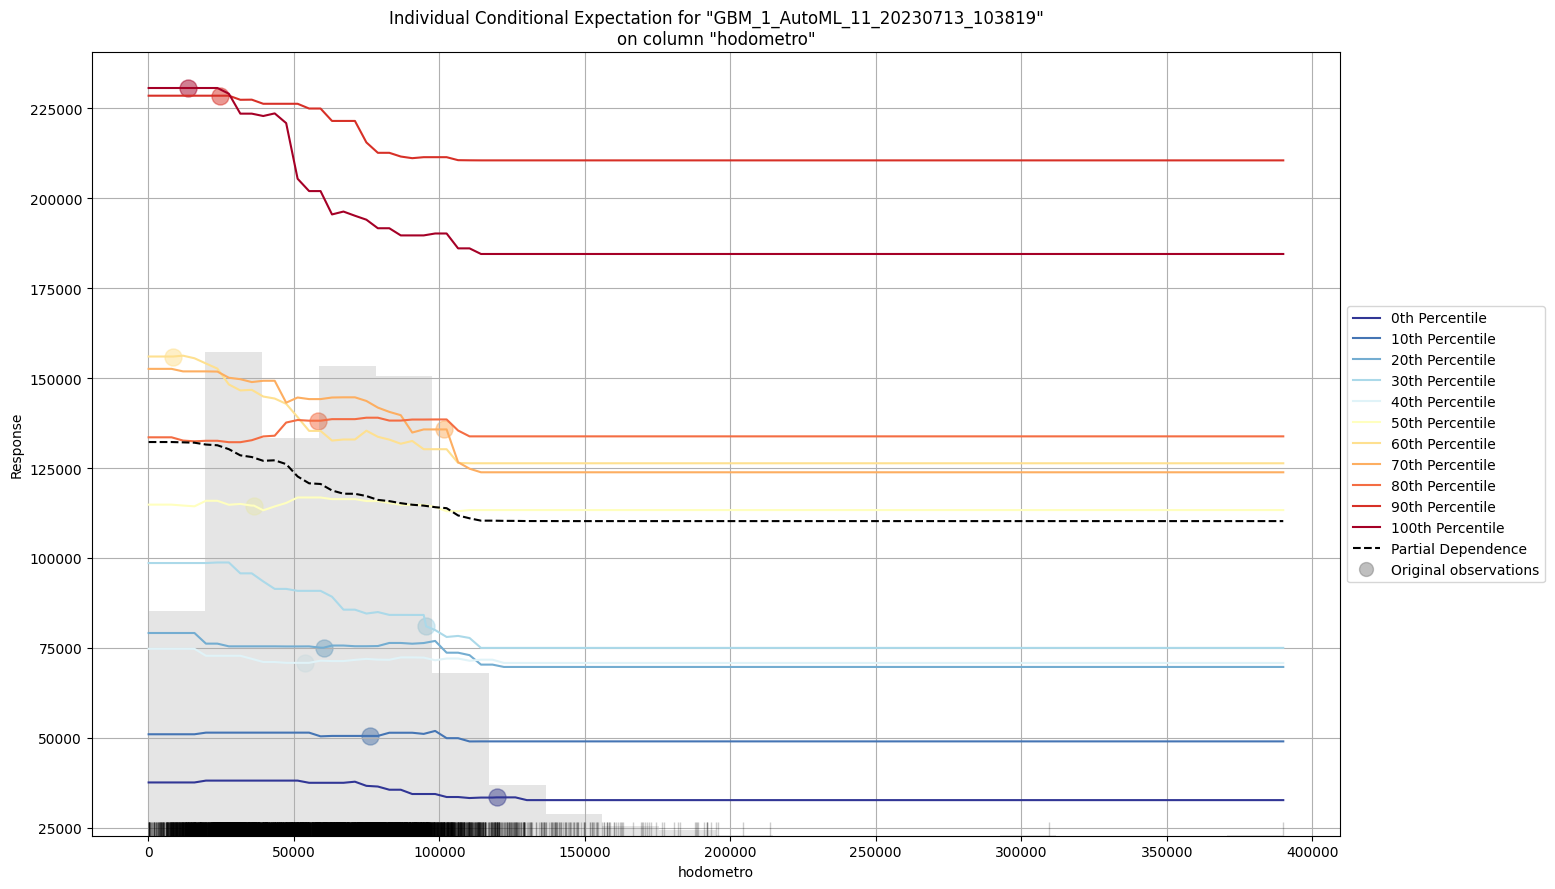

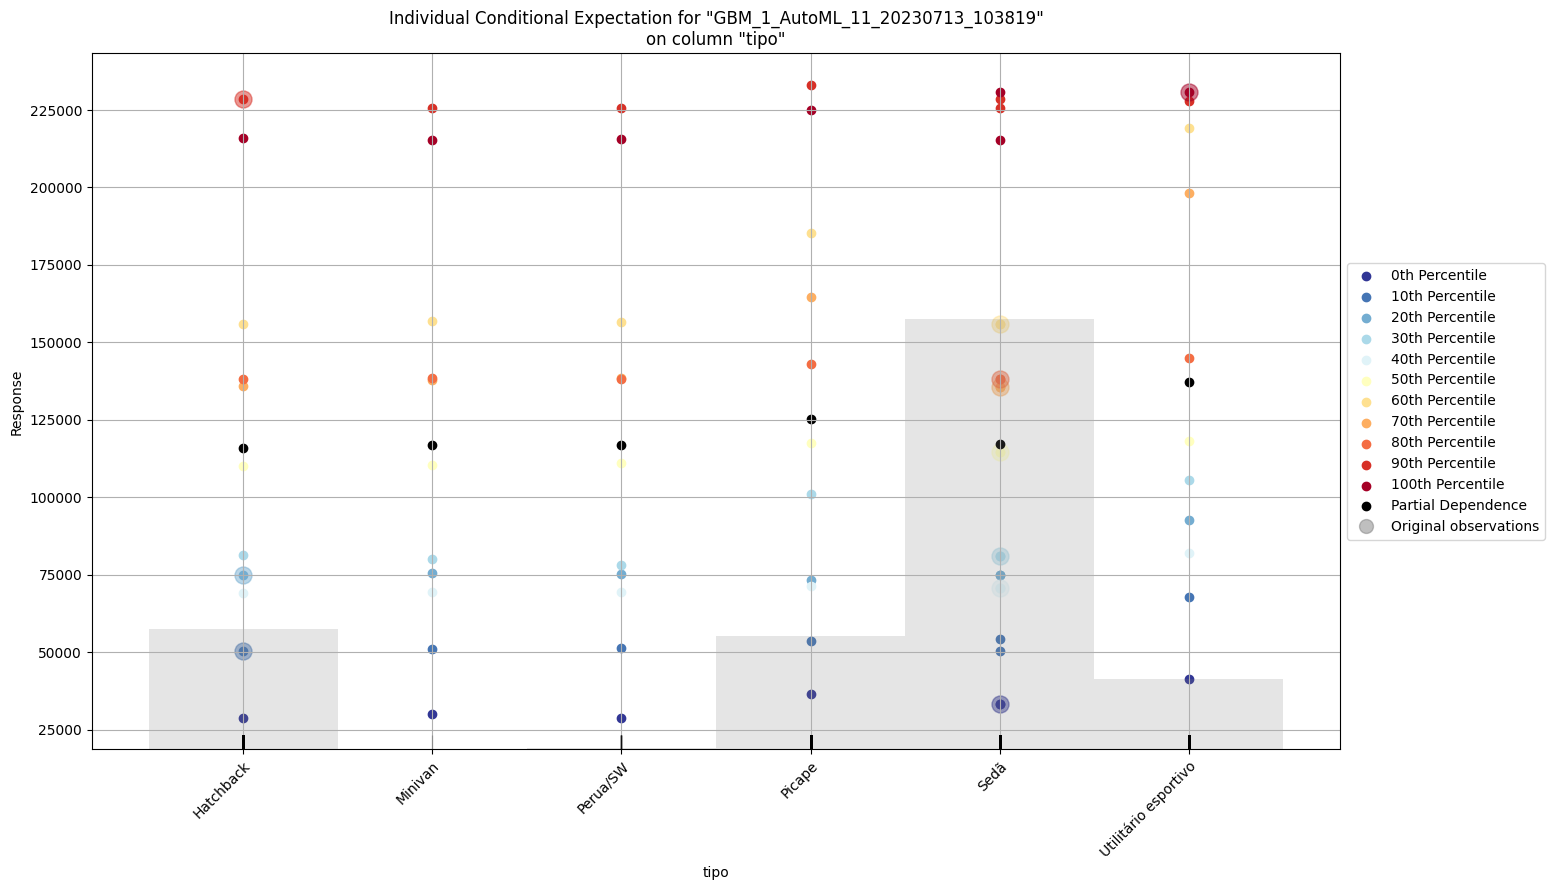

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_11_20230713_103819,28423.4,8.07887e+08,21337.7,0.258107,8.07887e+08,4170,0.030494,GBM
XGBoost_2_AutoML_11_20230713_103819,29489.2,8.69613e+08,22413.6,0.268177,8.69613e+08,10712,0.011544,XGBoost
XGBoost_1_AutoML_11_20230713_103819,29679.2,8.80855e+08,22458.7,0.270204,8.80855e+08,5168,0.007655,XGBoost
GLM_1_AutoML_11_20230713_103819,58835.7,3.46165e+09,47421.7,0.52469,3.46165e+09,540,0.001012,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [ ]:
model.explain(frame=test_data)

In [ ]:
model.leader.cross_validation_metrics_summary()


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,21954.1,234.85655,22081.748,22094.602,21789.955,22178.0,21626.197
mean_residual_deviance,867600510.0000000,14847712.0000000,885249410.0000000,875893120.0000000,865006780.0000000,866468740.0000000,845384320.0000000
mse,867600510.0000000,14847712.0000000,885249410.0000000,875893120.0000000,865006780.0000000,866468740.0000000,845384320.0000000
r2,0.7536725,0.0106141,0.7459456,0.7474380,0.7464626,0.7580948,0.7704212
residual_deviance,867600510.0000000,14847712.0000000,885249410.0000000,875893120.0000000,865006780.0000000,866468740.0000000,845384320.0000000
rmse,29454.193,252.46346,29753.143,29595.492,29410.998,29435.842,29075.494
rmsle,0.2614954,0.0016017,0.2613855,0.2623440,0.2632936,0.2614674,0.2589863


In [ ]:
pred = model.predict(test_data)
pred = pred.cbind(test_data['preco'])
df = pred.as_data_frame()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
df.assign(diff=lambda df: df["predict"] - df["preco"])["diff"].describe()

count      5692.000000
mean         -6.186064
std       28425.855198
min     -155592.019982
25%      -14961.733080
50%        2447.805151
75%       17496.312643
max      112366.069548
Name: diff, dtype: float64

In [ ]:
df = df.assign(diff=lambda df: df["predict"] - df["preco"]).sort_values(by=["predict"])

In [ ]:
import plotly.graph_objects as go

# Criar objeto Bar para cada coluna
bar1 = go.Histogram(x=df["predict"], name='Coluna 1')
bar2 = go.Histogram(x=df["preco"], name='Coluna 2')

# Definir layout do gráfico
layout = go.Layout(barmode='group', title='Gráfico de Barras')

# Criar figura com os objetos Bar
fig = go.Figure(data=[bar1, bar2])

# Exibir o gráfico
fig.show()